# Librerías y configuración

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Lectura de datos 

In [2]:
df = pd.read_excel('AllMetrics.xlsx')
df.head()

,Unnamed: 0,Scopus author ID,Most recent publication,Citations,Citations per Publication,Field-Weighted Citation Impact,h-index,Output in Top 10% Citation Percentiles (field-weighted),Oldest publication (since 1996),CiteScore,SNIP,h-index Ponderado
0,0,10038895100,2017,36,36.0,2.13,1,12.0,2017,7.4,1.45,1.0
1,1,10039007800,2018,24,24.0,3.10,1,7.0,2018,3.5,1.19,1.0
2,2,10039013100,2020,0,0.0,0.00,0,71.0,2020,2.6,1.00,0.0
3,3,10039034400,2019,25,25.0,3.72,1,5.0,2019,2.7,0.88,1.0
4,4,10039108900,2021,6,6.0,1.63,1,18.0,2021,16.8,2.29,1.0


In [3]:
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

,Scopus author ID,Most recent publication,Citations,Citations per Publication,Field-Weighted Citation Impact,h-index,Output in Top 10% Citation Percentiles (field-weighted),Oldest publication (since 1996),CiteScore,SNIP,h-index Ponderado
0,10038895100,2017,36,36.0,2.13,1,12.0,2017,7.4,1.45,1.0
1,10039007800,2018,24,24.0,3.10,1,7.0,2018,3.5,1.19,1.0
2,10039013100,2020,0,0.0,0.00,0,71.0,2020,2.6,1.00,0.0
3,10039034400,2019,25,25.0,3.72,1,5.0,2019,2.7,0.88,1.0
4,10039108900,2021,6,6.0,1.63,1,18.0,2021,16.8,2.29,1.0


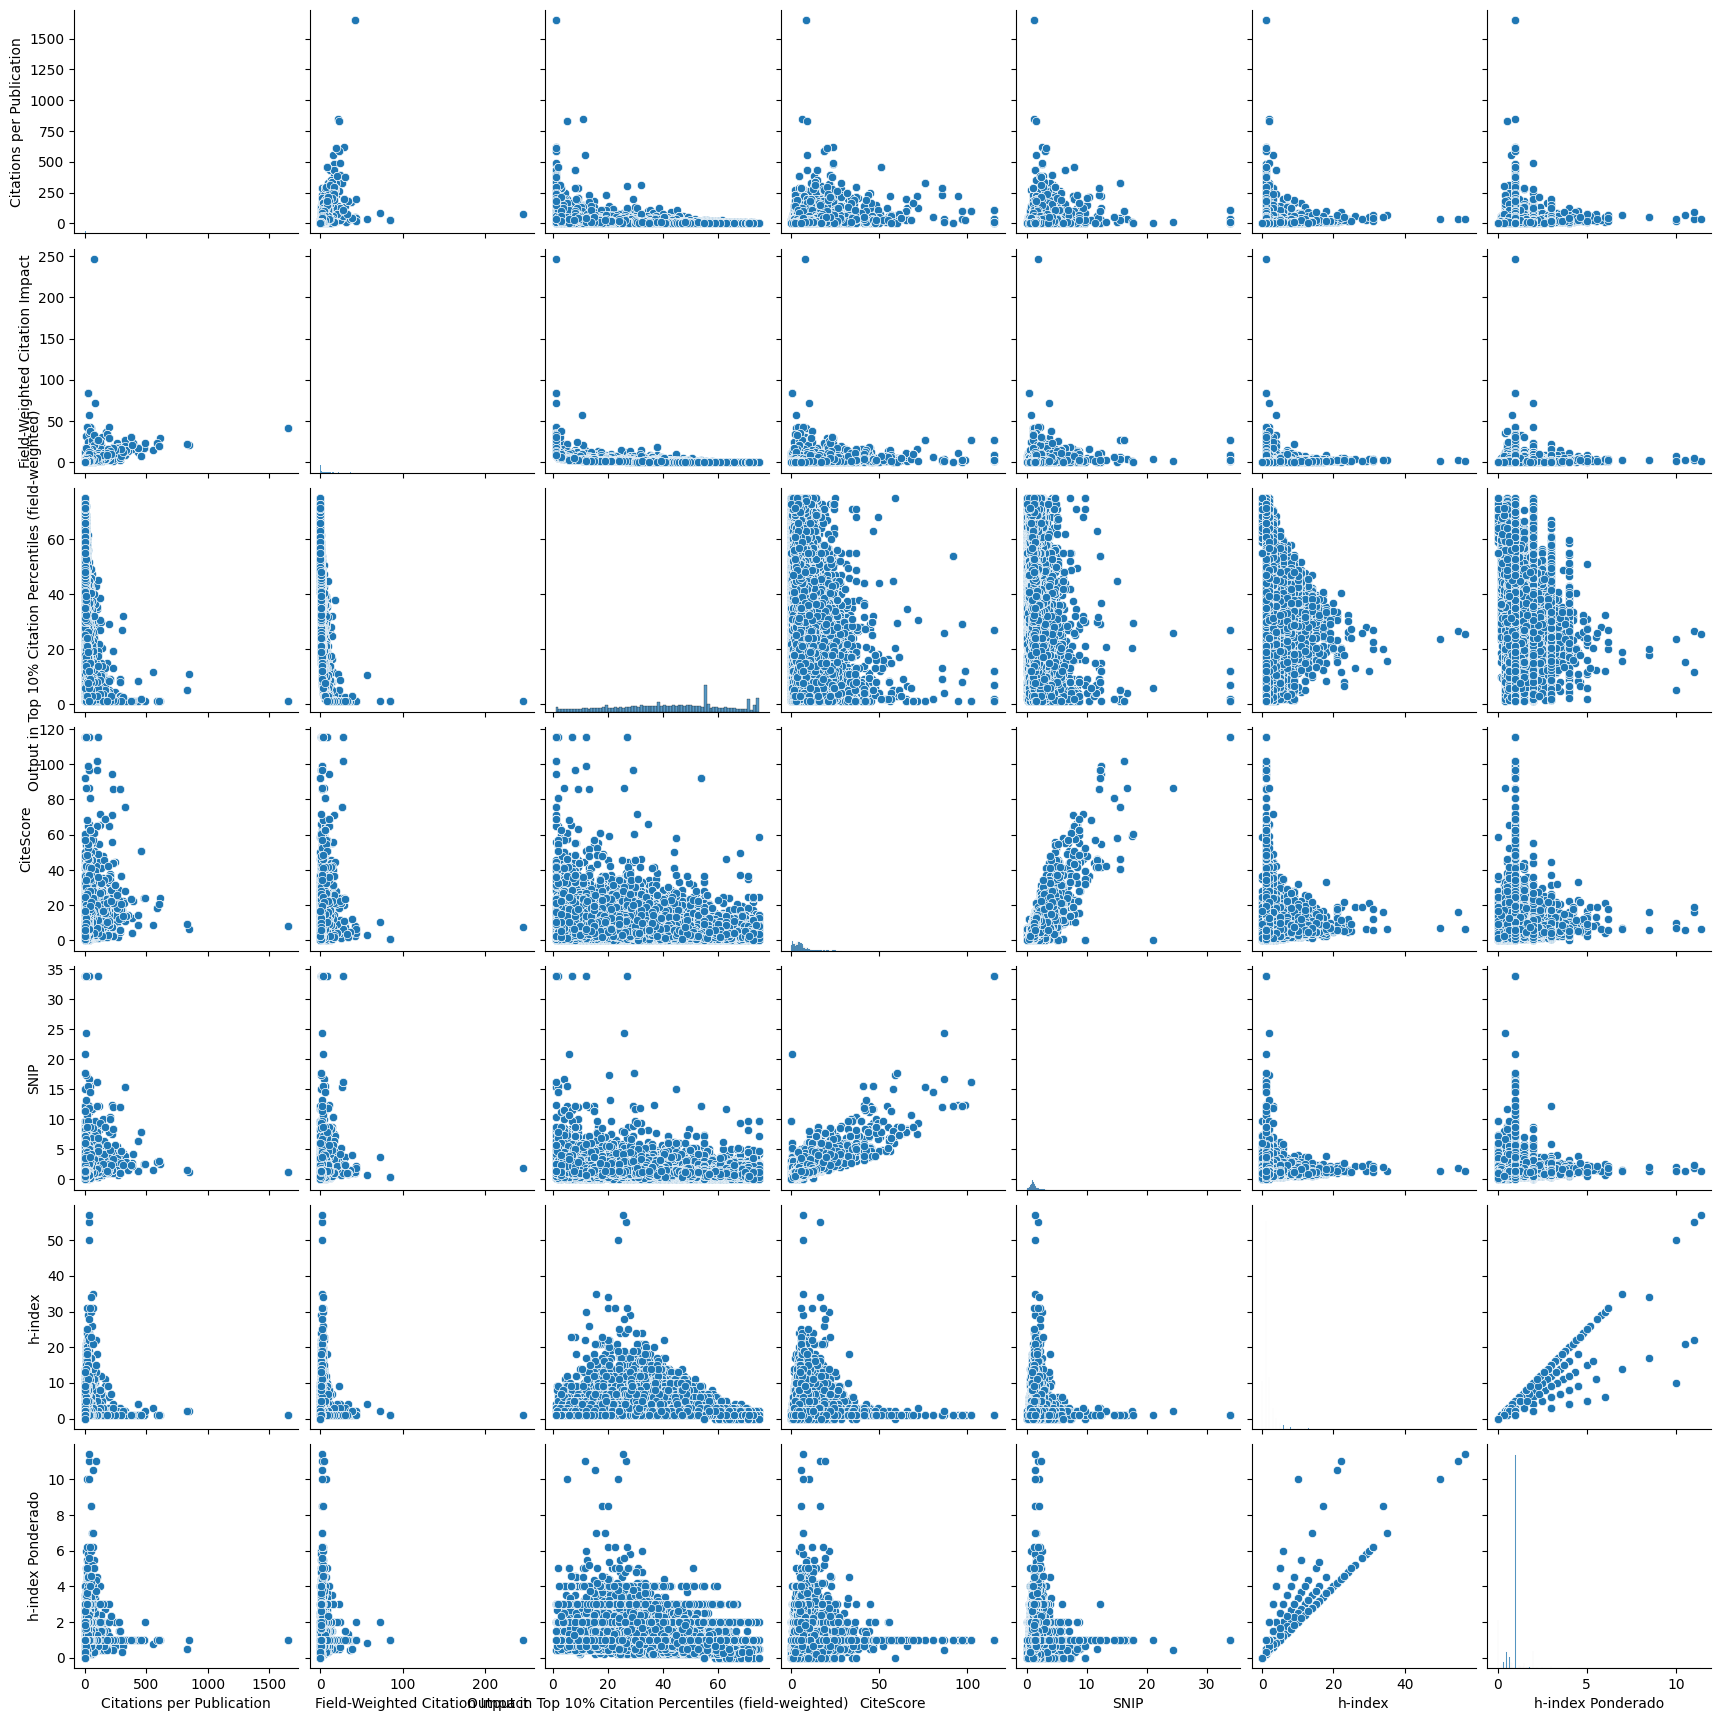

In [9]:
cols = ['Citations per Publication','Field-Weighted Citation Impact',
        'Output in Top 10% Citation Percentiles (field-weighted)',
        'CiteScore','SNIP','h-index','h-index Ponderado']
sns.pairplot(df[cols],height=2.5)
plt.show()